In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
df = pd.read_csv("/content/drive/MyDrive/IA/NuevoTPIA.csv")
#df = pd.read_csv("/content/drive/MyDrive/AI/Trabajo final /NuevoTPIA.csv")

In [57]:
df.columns =['fecha', 'SIN', 'Temperature', 'Humidity', 'PRSS', 'TPP6', 'U10M', 'V10M']

In [58]:
df['fecha'] = pd.to_datetime(df['fecha'], utc=True)

Verificacion si tiene correlacion las variables

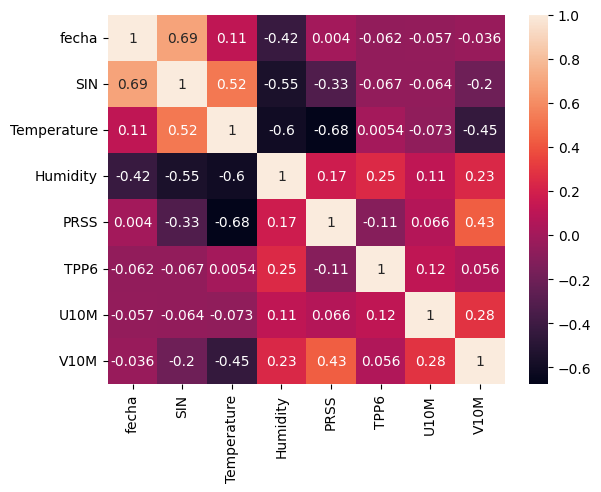

In [59]:
corr_matrix = df.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [60]:
df=df.drop(columns=['TPP6','U10M'])

In [61]:
df

,fecha,SIN,Temperature,Humidity,PRSS,V10M
0,2008-01-01 03:00:00+00:00,877.658352,24.463579,96.798320,999.585909,-1.142420
1,2008-01-01 04:00:00+00:00,855.606858,24.314531,96.065988,999.059392,-1.256589
2,2008-01-01 05:00:00+00:00,803.357910,24.165483,95.333657,998.532875,-1.370759
3,2008-01-01 06:00:00+00:00,750.530366,24.016435,94.601325,998.006359,-1.484929
4,2008-01-01 07:00:00+00:00,729.029900,23.667572,94.257455,998.982867,-1.629541
...,...,...,...,...,...,...
131457,2022-12-31 22:00:00+00:00,2917.003684,35.666498,25.449116,995.890558,-0.515961
131458,2022-12-31 23:00:00+00:00,3214.912340,33.147940,29.386493,996.157851,-0.236700
131459,2023-01-01 00:00:00+00:00,3280.046574,30.629383,33.323870,996.425145,0.042562
131460,2023-01-01 01:00:00+00:00,2955.971259,29.699868,35.320626,997.416281,-0.518552


pre procesamiento

In [62]:
df['hora'] = df['fecha'].dt.hour
df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes'] = df['fecha'].dt.month

In [63]:
df

,fecha,SIN,Temperature,Humidity,PRSS,V10M,hora,dia_semana,mes
0,2008-01-01 03:00:00+00:00,877.658352,24.463579,96.798320,999.585909,-1.142420,3,1,1
1,2008-01-01 04:00:00+00:00,855.606858,24.314531,96.065988,999.059392,-1.256589,4,1,1
2,2008-01-01 05:00:00+00:00,803.357910,24.165483,95.333657,998.532875,-1.370759,5,1,1
3,2008-01-01 06:00:00+00:00,750.530366,24.016435,94.601325,998.006359,-1.484929,6,1,1
4,2008-01-01 07:00:00+00:00,729.029900,23.667572,94.257455,998.982867,-1.629541,7,1,1
...,...,...,...,...,...,...,...,...,...
131457,2022-12-31 22:00:00+00:00,2917.003684,35.666498,25.449116,995.890558,-0.515961,22,5,12
131458,2022-12-31 23:00:00+00:00,3214.912340,33.147940,29.386493,996.157851,-0.236700,23,5,12
131459,2023-01-01 00:00:00+00:00,3280.046574,30.629383,33.323870,996.425145,0.042562,0,6,1
131460,2023-01-01 01:00:00+00:00,2955.971259,29.699868,35.320626,997.416281,-0.518552,1,6,1


In [64]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dfsca = scaler.fit_transform(df[['SIN','Temperature','Humidity','PRSS','V10M']])

In [65]:
dfsca = np.hstack((dfsca, df[['hora', 'dia_semana', 'mes']].values))

In [66]:
dfsca.shape

(131462, 8)

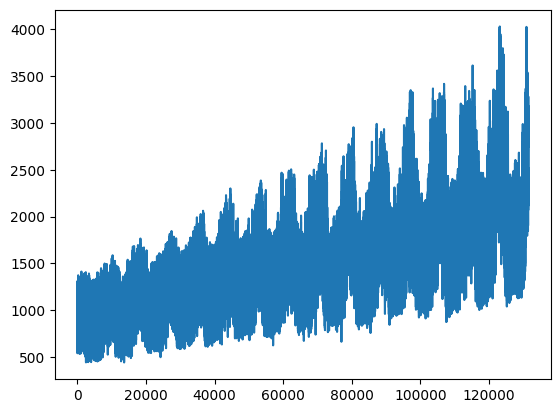

In [67]:
plt.plot(df.index, df['SIN'])
plt.show()

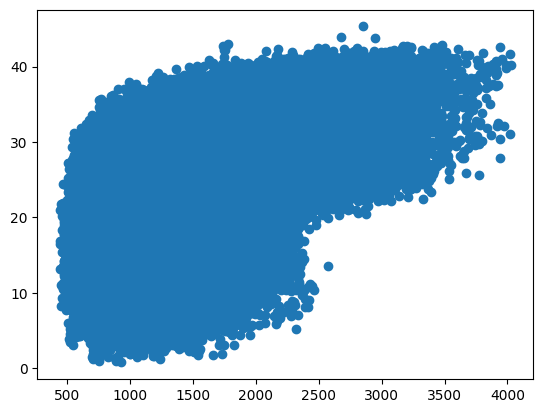

In [68]:
plt.scatter(df['SIN'], df['Temperature'])
plt.show()

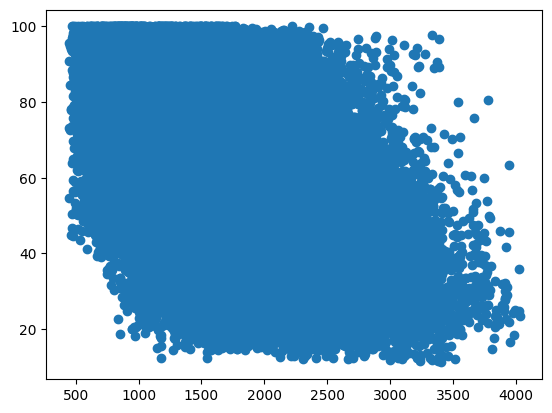

In [69]:
plt.scatter(df['SIN'], df['Humidity'])
plt.show()

In [70]:
def crear_secuencias(data, ventana):
    """
    Crea secuencias de datos temporales para LSTM.

    Args:
    - data: array numpy con las características (escalado si es necesario).
    - ventana: tamaño de la ventana (número de pasos históricos).

    Retorna:
    - X: características (entradas) con forma [num_muestras, ventana, num_características].
    - y: etiquetas (salidas) con forma [num_muestras, 1].
    """
    X, y = [], []
    for i in range(len(data) - ventana):
        # Toma `ventana` filas como características
        X.append(data[i:i+ventana, :-1])  # Excluye la columna de demanda para las características
        # Toma la siguiente fila como etiqueta (la demanda a predecir)
        y.append(data[i+ventana, 0])  # Asume que la demanda está en la primera columna
    return np.array(X), np.array(y)

In [71]:
# Crear las secuencias a partir de los datos escalados
ventana = 24  # Por ejemplo, usar 24 horas de historial
X, y = crear_secuencias(dfsca, ventana)


In [72]:
X.shape

(131438, 24, 7)

In [73]:
y.shape

(131438,)

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
X

array([[[ 0.12083945,  0.53214464,  0.96395181, ...,  0.46427948,
          3.        ,  1.        ],
        [ 0.11468283,  0.52880003,  0.95570638, ...,  0.45883691,
          4.        ,  1.        ],
        [ 0.10009527,  0.52545542,  0.94746095, ...,  0.45339434,
          5.        ,  1.        ],
        ...,
        [ 0.18738967,  0.5651597 ,  0.90273118, ...,  0.50653535,
          0.        ,  2.        ],
        [ 0.18060695,  0.55544719,  0.91852341, ...,  0.49864065,
          1.        ,  2.        ],
        [ 0.15512121,  0.54573468,  0.93431563, ...,  0.49074595,
          2.        ,  2.        ]],

       [[ 0.11468283,  0.52880003,  0.95570638, ...,  0.45883691,
          4.        ,  1.        ],
        [ 0.10009527,  0.52545542,  0.94746095, ...,  0.45339434,
          5.        ,  1.        ],
        [ 0.08534618,  0.52211081,  0.93921551, ...,  0.44795177,
          6.        ,  1.        ],
        ...,
        [ 0.18060695,  0.55544719,  0.91852341, ...,  

In [76]:
y

array([0.12653382, 0.10504832, 0.09330289, ..., 0.79157004, 0.7010904 ,
       0.64285798])

In [77]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Definir el modelo LSTM
modelo = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Predicción de un único valor: la demanda
])

# Compilar el modelo
modelo.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
historial = modelo.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 78s 23ms/step - loss: 0.0091 - val_loss: 9.8095e-04
Epoch 2/50
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 82s 23ms/step - loss: 0.0014 - val_loss: 7.5260e-04
Epoch 3/50
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 79s 22ms/step - loss: 0.0010 - val_loss: 6.2671e-04
Epoch 4/50
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - loss: 9.0469e-04 - val_loss: 5.4989e-04
Epoch 5/50
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 77s 23ms/step - loss: 8.1308e-04 - val_loss: 5.2550e-04
Epoch 6/50
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 73s 22ms/step - loss: 7.8225e-04 - val_loss: 5.4401e-04
Epoch 7/50
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 81s 22ms/step - loss: 7.4779e-04 - val_loss: 5.3750e-04
Epoch 8/50
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 87s 24ms/step - loss: 7.1280e-04 - val_loss: 3.9661e-04
Epoch 9/50
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 76s 23ms/step - loss: 6.5518e-04 - val_loss: 3.5433e-04
Epoch 10/50
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 76s 23ms/step - loss: 6.2313e-04 - val_loss: 3.8310e-04
Epoch 11/50
3286/3286 ━━━━━━━━━

In [78]:
# Evaluación del modelo
loss = modelo.evaluate(X_test, y_test)
print(f'Pérdida (MSE): {loss}')

# Hacer predicciones
predicciones = modelo.predict(X_test)

822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 2.4518e-04
Pérdida (MSE): 0.00023936845536809415
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


In [79]:
data_scaled = dfsca

In [80]:
if len(predicciones.shape) == 1:
    predicciones = predicciones.reshape(-1, 1)

print("Forma de predicciones:", predicciones.shape)

Forma de predicciones: (26288, 1)


In [81]:
zeros = np.zeros((predicciones.shape[0], 4))

# Concatenar predicciones con las columnas de ceros
predicciones_expandida = np.hstack((predicciones, zeros))

print("Forma de predicciones_expandida:", predicciones_expandida.shape)

Forma de predicciones_expandida: (26288, 5)


In [82]:
# Desescalar las predicciones
predicciones_desescaladas = scaler.inverse_transform(predicciones_expandida)

# Extraer únicamente la columna de demanda (SIN)
predicciones_finales = predicciones_desescaladas[:, 0]

print("Forma de predicciones_finales:", predicciones_finales.shape)

Forma de predicciones_finales: (26288,)


In [83]:
if len(y_test.shape) == 1:
    y_test = y_test.reshape(-1, 1)

print("Forma de y_test:", y_test.shape)

Forma de y_test: (26288, 1)


In [84]:
zeros2 = np.zeros((y_test.shape[0], 4))

# Concatenar predicciones con las columnas de ceros
y_test_expandida = np.hstack((y_test, zeros2))

print("Forma de predicciones_expandida:", y_test_expandida.shape)

Forma de predicciones_expandida: (26288, 5)


In [85]:
# Desescalar las predicciones
y_test_desescaladas = scaler.inverse_transform(y_test_expandida)

# Extraer únicamente la columna de demanda (SIN)
y_test_final = y_test_desescaladas[:, 0]

print("Forma de predicciones_finales:", y_test_final.shape)

Forma de predicciones_finales: (26288,)


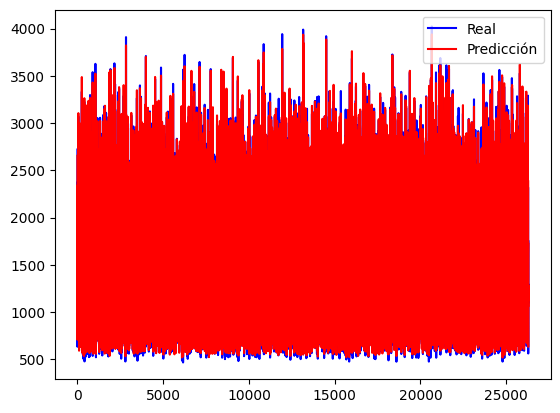

In [86]:
# Graficar los valores reales y predichos
plt.plot(y_test_final, label='Real', color='blue')
plt.plot(predicciones_finales, label='Predicción', color='red')
plt.legend()
plt.show()

In [87]:
df['fecha']

,fecha
0,2008-01-01 03:00:00+00:00
1,2008-01-01 04:00:00+00:00
2,2008-01-01 05:00:00+00:00
3,2008-01-01 06:00:00+00:00
4,2008-01-01 07:00:00+00:00
...,...
131457,2022-12-31 22:00:00+00:00
131458,2022-12-31 23:00:00+00:00
131459,2023-01-01 00:00:00+00:00
131460,2023-01-01 01:00:00+00:00


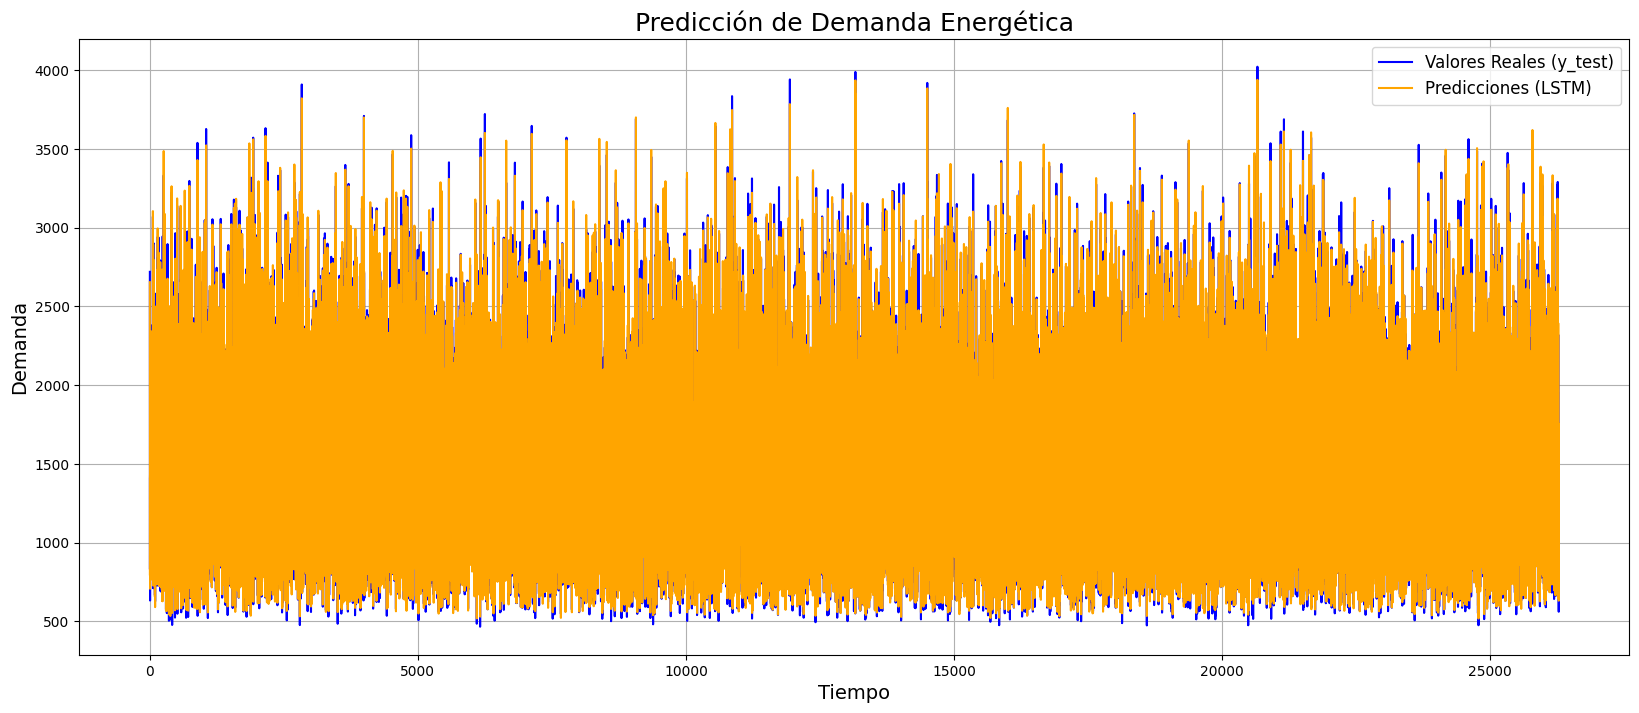

In [89]:
# Ajustar el tamaño del gráfico
plt.figure(figsize=(20, 8))  # Ancho=16 pulgadas, Alto=8 pulgadas

# Graficar valores reales
plt.plot(y_test_final, label="Valores Reales (y_test)", color="blue")

# Graficar predicciones
plt.plot(predicciones_finales, label="Predicciones (LSTM)", color="orange")

plt.title("Predicción de Demanda Energética", fontsize=18)  # Ajustar el tamaño del título
plt.xlabel("Tiempo", fontsize=14)  # Ajustar el tamaño de la etiqueta del eje x
plt.ylabel("Demanda", fontsize=14)  # Ajustar el tamaño de la etiqueta del eje y
plt.legend(fontsize=12)  # Ajustar el tamaño de la leyenda
plt.grid(True)  # Agregar una cuadrícula para mejor visualización
plt.show()

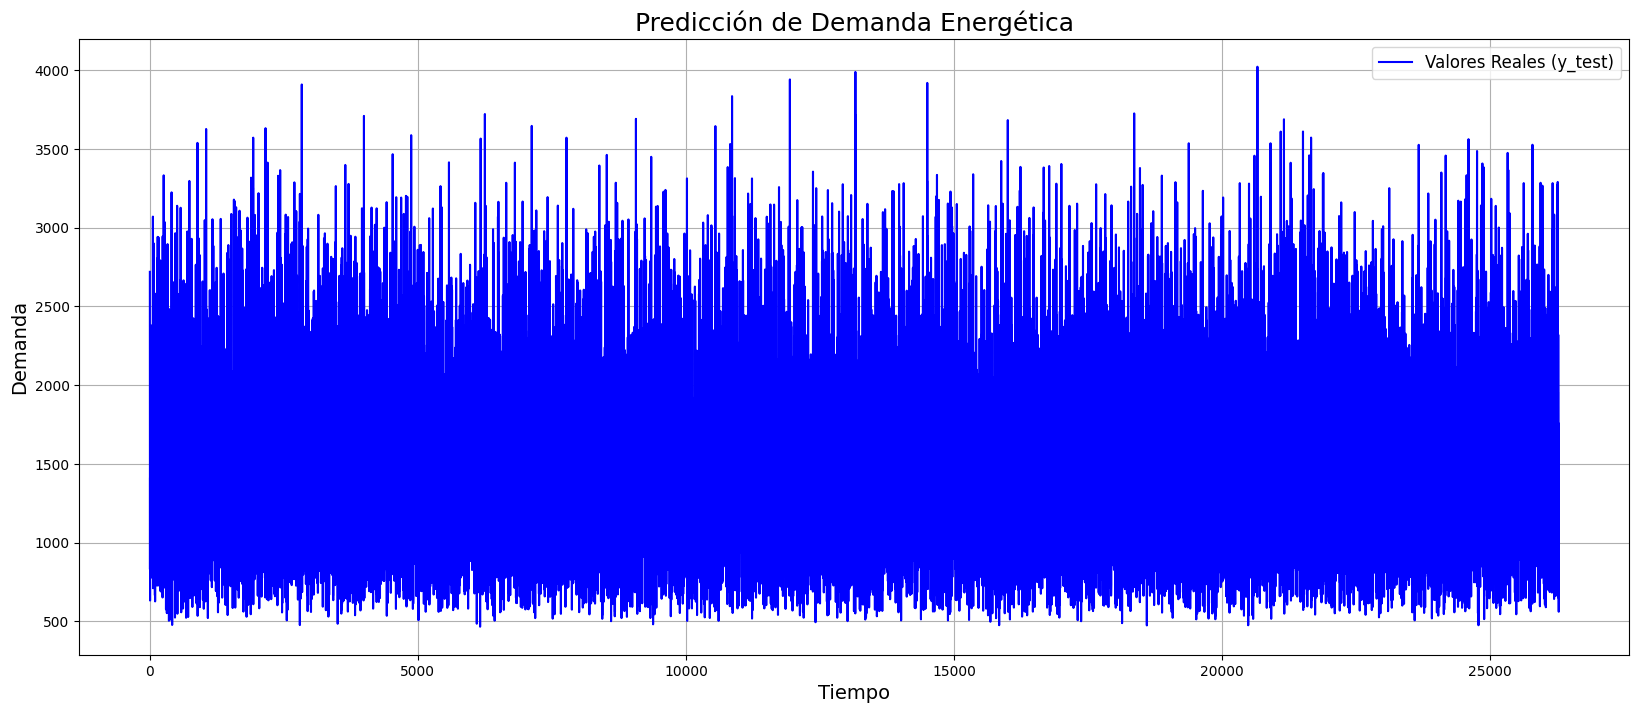

In [90]:
plt.figure(figsize=(20, 8))  # Ancho=16 pulgadas, Alto=8 pulgadas

# Graficar valores reales
plt.plot(y_test_final, label="Valores Reales (y_test)", color="blue")


plt.title("Predicción de Demanda Energética", fontsize=18)  # Ajustar el tamaño del título
plt.xlabel("Tiempo", fontsize=14)  # Ajustar el tamaño de la etiqueta del eje x
plt.ylabel("Demanda", fontsize=14)  # Ajustar el tamaño de la etiqueta del eje y
plt.legend(fontsize=12)  # Ajustar el tamaño de la leyenda
plt.grid(True)  # Agregar una cuadrícula para mejor visualización
plt.show()

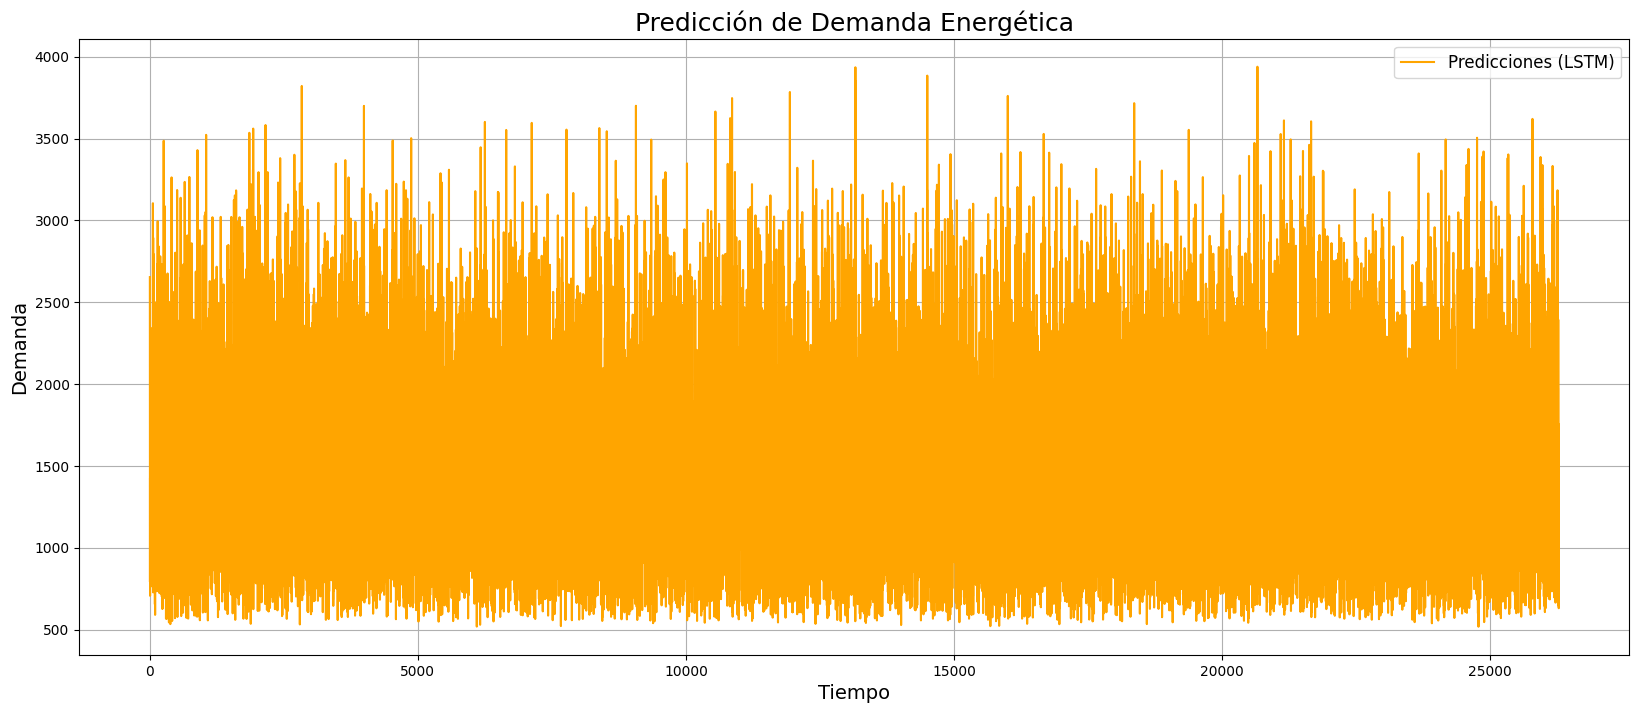

In [91]:
plt.figure(figsize=(20, 8))  # Ancho=16 pulgadas, Alto=8 pulgadas


# Graficar predicciones
plt.plot(predicciones_finales, label="Predicciones (LSTM)", color="orange")

plt.title("Predicción de Demanda Energética", fontsize=18)  # Ajustar el tamaño del título
plt.xlabel("Tiempo", fontsize=14)  # Ajustar el tamaño de la etiqueta del eje x
plt.ylabel("Demanda", fontsize=14)  # Ajustar el tamaño de la etiqueta del eje y
plt.legend(fontsize=12)  # Ajustar el tamaño de la leyenda
plt.grid(True)  # Agregar una cuadrícula para mejor visualización
plt.show()

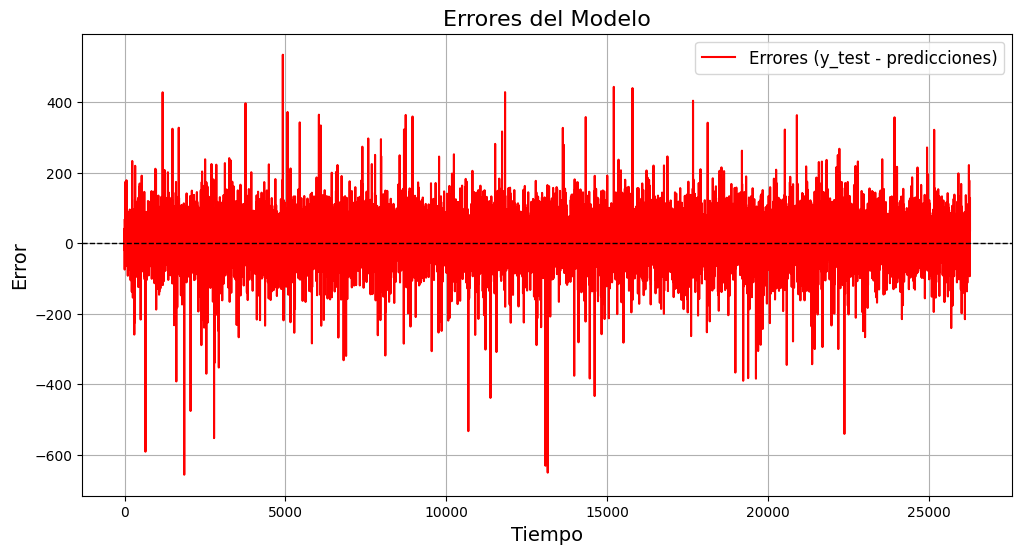

In [92]:
errores = y_test_final - predicciones_finales  # Diferencias entre valores reales y predicciones

plt.figure(figsize=(12, 6))
plt.plot(errores, label="Errores (y_test - predicciones)", color="red")
plt.title("Errores del Modelo", fontsize=16)
plt.xlabel("Tiempo", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.axhline(0, color="black", linestyle="--", linewidth=1)  # Línea en y=0
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

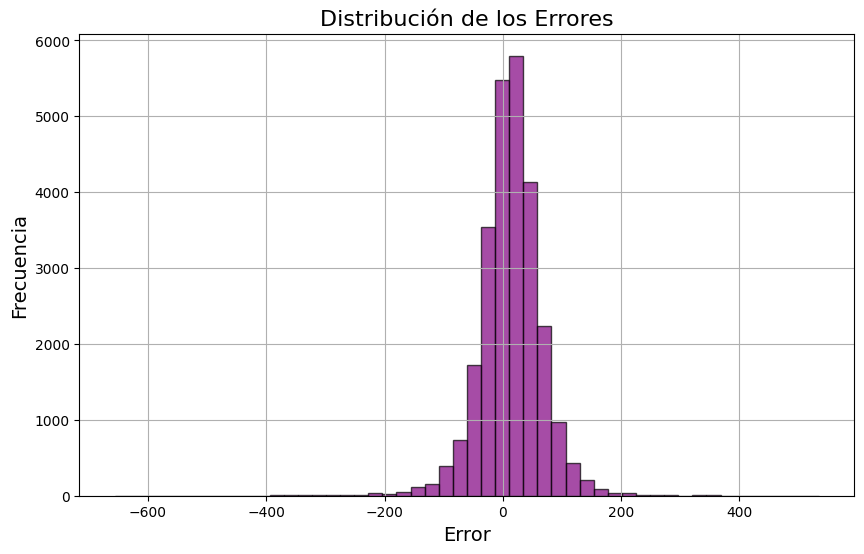

In [93]:
plt.figure(figsize=(10, 6))
plt.hist(errores, bins=50, color="purple", alpha=0.7, edgecolor="black")
plt.title("Distribución de los Errores", fontsize=16)
plt.xlabel("Error", fontsize=14)
plt.ylabel("Frecuencia", fontsize=14)
plt.grid(True)
plt.show()

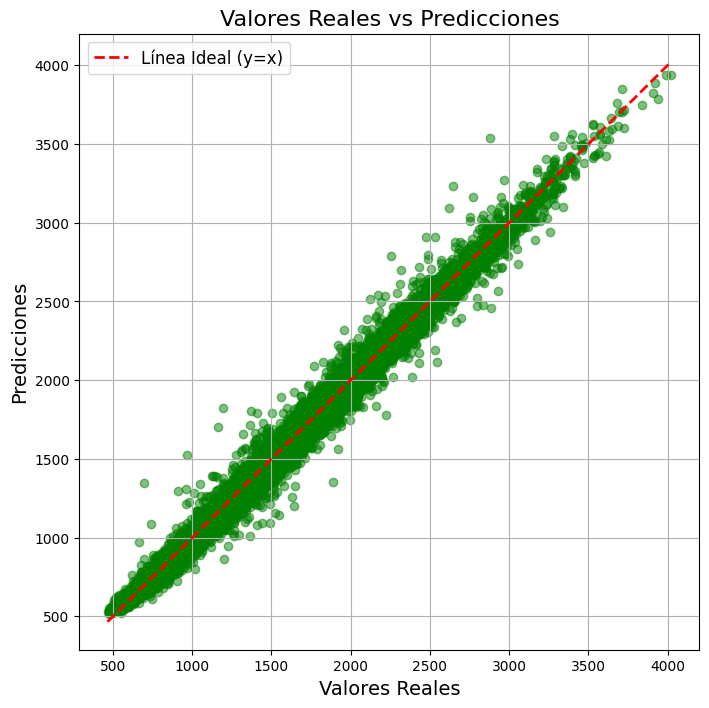

In [94]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test_final, predicciones_finales, alpha=0.5, color="green")
plt.plot([min(y_test_final), max(y_test_final)], [min(y_test_final), max(y_test_final)],
         color="red", linestyle="--", linewidth=2, label="Línea Ideal (y=x)")
plt.title("Valores Reales vs Predicciones", fontsize=16)
plt.xlabel("Valores Reales", fontsize=14)
plt.ylabel("Predicciones", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

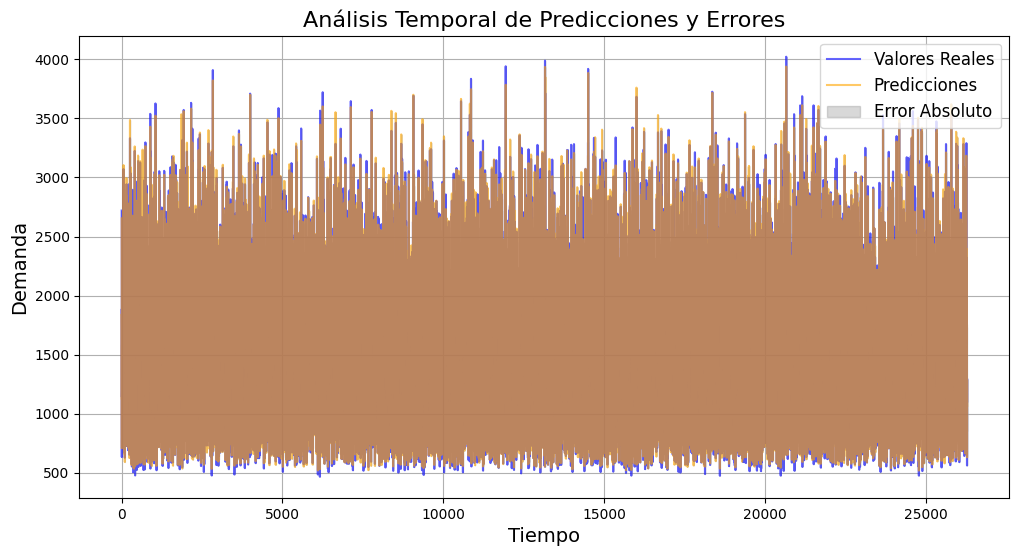

In [95]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_final, label="Valores Reales", color="blue", alpha=0.6)
plt.plot(predicciones_finales, label="Predicciones", color="orange", alpha=0.6)
plt.fill_between(range(len(errores)), y_test_final, predicciones_finales,
                 color="gray", alpha=0.3, label="Error Absoluto")
plt.title("Análisis Temporal de Predicciones y Errores", fontsize=16)
plt.xlabel("Tiempo", fontsize=14)
plt.ylabel("Demanda", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

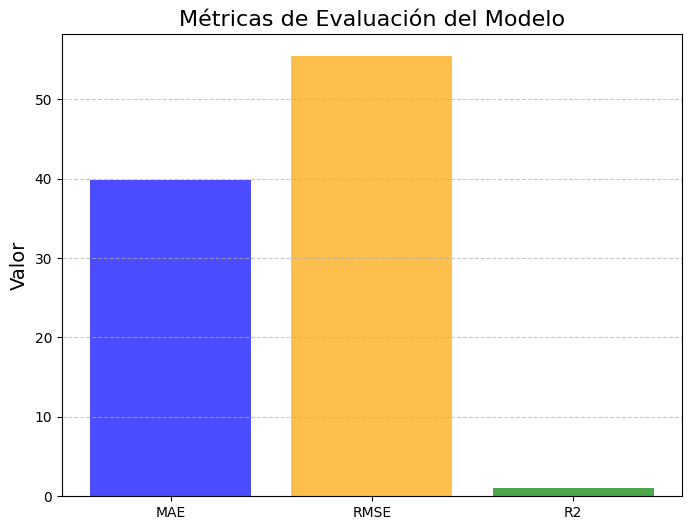

In [96]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calcular métricas
mae = mean_absolute_error(y_test_final, predicciones_finales)
rmse = np.sqrt(mean_squared_error(y_test_final, predicciones_finales))
r2 = r2_score(y_test_final, predicciones_finales)

# Crear gráfico de barras
metricas = ['MAE', 'RMSE', 'R2']
valores = [mae, rmse, r2]

plt.figure(figsize=(8, 6))
plt.bar(metricas, valores, color=['blue', 'orange', 'green'], alpha=0.7)
plt.title("Métricas de Evaluación del Modelo", fontsize=16)
plt.ylabel("Valor", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [97]:
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 39.77068978620581
RMSE: 55.41515857228985
R2: 0.9892238807939658


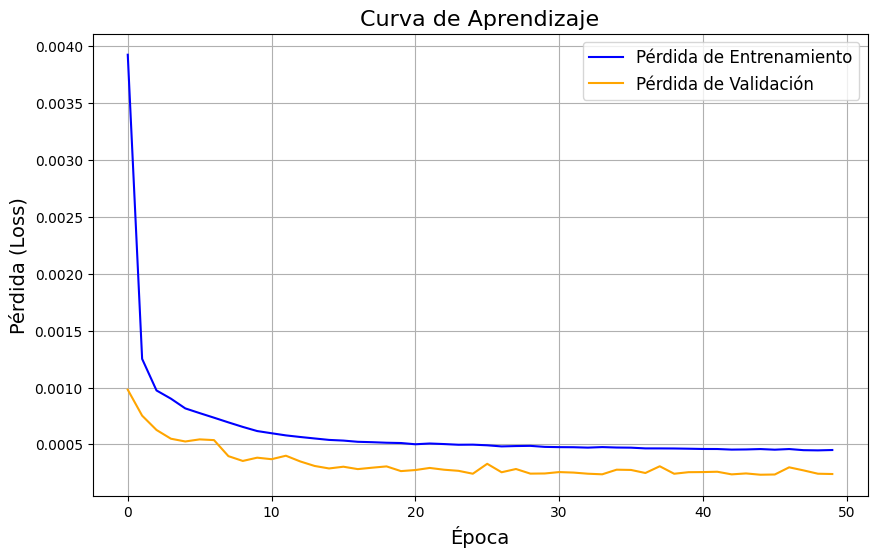

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(historial.history['loss'], label="Pérdida de Entrenamiento", color="blue")
plt.plot(historial.history['val_loss'], label="Pérdida de Validación", color="orange")
plt.title("Curva de Aprendizaje", fontsize=16)
plt.xlabel("Época", fontsize=14)
plt.ylabel("Pérdida (Loss)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

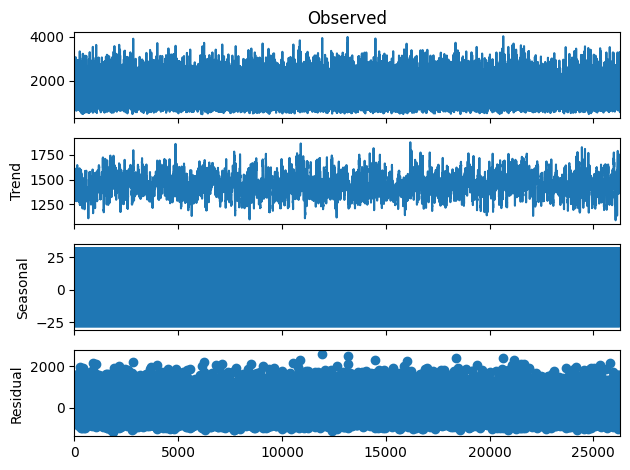

In [99]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomponer la serie original
result = seasonal_decompose(y_test_final, period=24, model='additive')  # Ajusta el periodo según los datos
result.plot()
plt.show()

In [100]:
# Comparar distribuciones
variables = ['SIN', 'Temperature', 'Humidity', 'PRSS', 'V10M']
for var in variables:
    sns.kdeplot(X_train[var], label='Entrenamiento')
    sns.kdeplot(X_test[var], label='Test')
    plt.title(f'Distribución de {var}')
    plt.legend()
    plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
noisy_test = X_test.copy()
noisy_test['Temperature'] += np.random.normal(0, 0.5, size=X_train.shape[0])  # Ruido pequeño
noisy_test['V10M'] *= np.random.uniform(0.9, 1.1, size=X_test.shape[0])

In [ ]:
# Crear datos extremos
extreme_test = pd.DataFrame({
    'SIN': [min(train_data['SIN']), max(train_data['SIN'])],
    'Temperature': [min(train_data['Temperature']), max(train_data['Temperature'])],
    'Humidity': [min(train_data['Humidity']), max(train_data['Humidity'])],
    'PRSS': [min(train_data['PRSS']), max(train_data['PRSS'])],
    'V10M': [min(train_data['V10M']), max(train_data['V10M'])]
})

In [ ]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

print("Train RMSE:", mean_squared_error(y_train, train_pred, squared=False))
print("Validation RMSE:", mean_squared_error(y_val, val_pred, squared=False))
print("Test RMSE:", mean_squared_error(y_test, test_pred, squared=False))